In [1]:
import sys
print(sys.executable)
import tensorflow as tf
print('tf', tf.__version__)


c:\Users\ramna\OneDrive\Desktop\hand-gesture project\venv\Scripts\python.exe
tf 2.20.0


In [ ]:
#  small env setup (run once each session)
import os

# optional: silence oneDNN informational logs
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# optional: avoid TF warnings in notebook
import warnings
warnings.filterwarnings('ignore')


In [3]:
#  imports and configuration

import json, time, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Paths - adjust if your structure differs
PROJECT_ROOT = Path.cwd().parent  # if notebook is in notebooks/, PROJECT_ROOT points to project folder
DATA_DIR = PROJECT_ROOT / "data" / "hand_gesture"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"
MODEL_DIR = PROJECT_ROOT / "models"
CLASSIND_FILE = PROJECT_ROOT / "class_indices.json"

MODEL_DIR.mkdir(exist_ok=True, parents=True)

IMG_SIZE = 128
BATCH = 32
EPOCHS = 15


In [5]:
#  verify dataset layout

print("Notebook working directory:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR exists:", DATA_DIR.exists())
print("TRAIN_DIR exists:", TRAIN_DIR.exists())
print("TEST_DIR exists:", TEST_DIR.exists())
if TRAIN_DIR.exists():
    print("Train subfolders (first 20):", sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])[:20])
else:
    raise FileNotFoundError(f"Train folder not found at {TRAIN_DIR}. Please unzip dataset into data/hand_gesture/")


Notebook working directory: c:\Users\ramna\OneDrive\Desktop\hand-gesture project
PROJECT_ROOT: c:\Users\ramna\OneDrive\Desktop
DATA_DIR exists: True
TRAIN_DIR exists: True
TEST_DIR exists: True
Train subfolders (first 20): ['train']


In [6]:
#  create data generators

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    str(TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_aug.flow_from_directory(
    str(TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

# Save class indices (needed for live demo)

with open(CLASSIND_FILE, 'w') as f:
    json.dump(train_gen.class_indices, f)

NUM_CLASSES = len(train_gen.class_indices)
print("Number of classes:", NUM_CLASSES)
print("Class indices saved to:", CLASSIND_FILE)


Found 18000 images belonging to 1 classes.
Found 6000 images belonging to 1 classes.
Number of classes: 1
Class indices saved to: c:\Users\ramna\OneDrive\Desktop\class_indices.json


In [7]:
#  build transfer-learning model

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False  # freeze

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
#  train (monitor validation on test_gen)

ckpt_path = str(MODEL_DIR / "best_model.h5")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model
final_path = MODEL_DIR / "final_model.h5"
model.save(final_path)
print("Final model saved to:", final_path)


Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - loss: 0.0000e+00

563/563 ━━━━━━━━━━━━━━━━━━━━ 131s 227ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 126s 224ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 129s 228ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 241ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 131s 233ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 135s 240ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 242ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Final model saved to: c:\Users\ramna\OneDrive\Desktop\models\final_model.h5


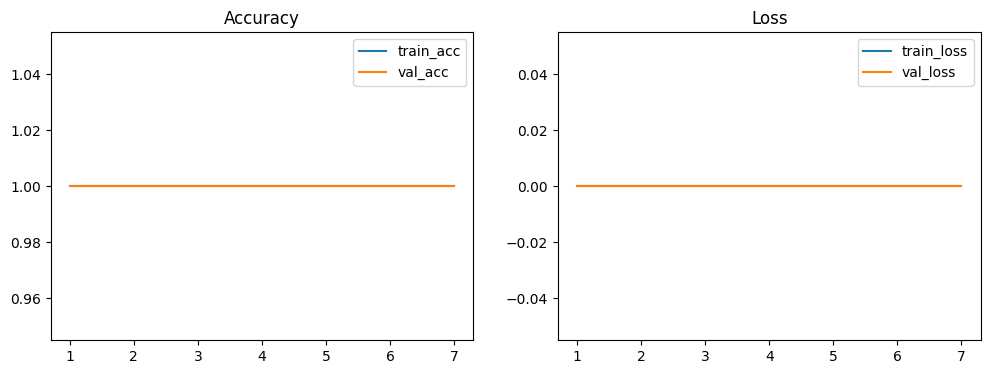

In [9]:
#  visualize

import matplotlib.pyplot as plt
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs_range = range(1, len(acc)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train_loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()


In [10]:
#  evaluation & report

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# predict on test set

steps = max(1, test_gen.samples // BATCH + 1)
preds = model.predict(test_gen, steps=steps)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes[:len(y_pred)]

labels = list(train_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=labels))


# Confusion matrix (print small sample)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)


188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step
              precision    recall  f1-score   support

       train       1.00      1.00      1.00      6000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion matrix shape: (1, 1)
